# Анализ результатов A/B теста

В качестве учебного проекта используется тестовый датасет «A/B Testing» взятый с сайта [kaggle.com]( http://kaggle.com).

На сайте e-commerce компании был проведен A/B тест (изменение внешнего вида стартовой страницы для увеличения CTR)

__Задача:__ Определить по результатам теста, нужно ли менять стартовую страницу на страницу в выборке В.

In [87]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [6]:
ab = pd.read_csv('ab_test.csv')

## Первоначальный анализ и подготовка данных

In [8]:
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
#Проверим на наличие ошибок
ab.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

Мы видим, что в группе __"control"__ были люди, которые видели новую страницу (1928), а  группе __"treatment"__ старую (1965), для соблюдение методологии нужно удалить их данные

In [30]:
#Отберем только подходящие значения
ab_clened = ab.query('group == "control" & landing_page == "old_page" \
                    | group == "treatment" & landing_page == "new_page"')

In [53]:
#Сделаем проверку
ab_clened.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


Теперь проверим, есть ли пользователи, которые несколько раз попадаются в выборке

In [54]:
ab_clened[ab_clened.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Пользователь ни разу не совершил конверсию, поэтому уберем его дубликат (только второе посещение)

In [55]:
ab_clened = ab_clened.drop_duplicates(subset='user_id', keep="first")

In [71]:
#Разделим данные на выборки А и В
a = ab_clened.query('group == "control"')
b = ab_clened.query('group == "treatment"')
a_CTR = a_click / (a_click + a_noclick)
b_CTR = b_click / (b_click + b_noclick)

In [80]:
#Найдем количество пользователей в А и В, где была конверсия, а где нет
a_click = a.converted.sum()
a_noclick = a.converted.shape[0] - a.converted.sum()
b_click = b.converted.sum()
b_noclick = b.converted.shape[0] - b.converted.sum()

Теперь посмотрим на конверсию на старой и новой странице

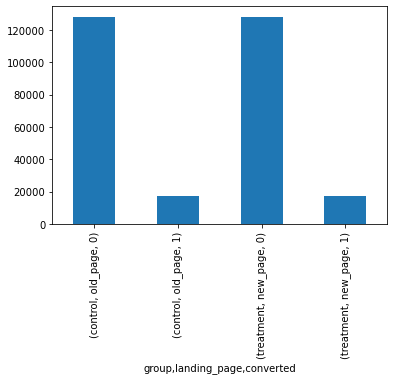

In [61]:
groups = ab_clened.groupby(['group','landing_page','converted']).size()
groups.plot.bar();

In [122]:
CTR_A = round(a_click / (a_click + a_noclick)*100,2)
CTR_B = round(b_click / (b_click + b_noclick)*100,2)
print('CTR в А: {} %'.format(CTR_A))
print('CTR в B: {} %'.format(CTR_B))

CTR в А: 12.04 %
CTR в B: 11.88 %


Мы видим, что количество пользователей в выборке А и В примерно одинаково.

Также как показатель CTR, но более уверенно о его различии можно будет сказать после применения статистического критерия.

## Критерий хи-квадрат 

In [88]:
#Поместим данные в массив для применения критерия хи-квадрат
T = np.array([[a_click, a_noclick], [b_click, b_noclick]])

In [109]:
#Проверяем значимость результатов
#Значений достаточно много, поэтому поправку Йетса не применяем
print('p-value:',scipy.stats.chi2_contingency(T,correction=False)[1])

p-value: 0.18988337448194853


Результат больше 0,05.

Cледовательно, мы не можем отвергнуть нулевую гипотезу об отсутствии статистически значимых результатов

Таким образом, изменение стартовой страницы не повлияло на количество кликов, что мы подтвердили, применив критерий хи-квадрат Пирсона.

__Замена стартовой страницы на страницу из выборки В, не рекомендуется.__